In [160]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
import os 
import pandas as pd
from   collections import Counter
import pickle
import seaborn as sns

In [164]:
read    = lambda f      : cv2.imread(f, cv2.IMREAD_GRAYSCALE)
norm    = lambda I      : cv2.normalize(I, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
dct     = lambda I      : cv2.dct(I.astype(np.float32))
idct    = lambda I      : cv2.idct(I.astype(np.float32))
first   = lambda x      : int(str("{:.2e}".format(x))[0]) if x > 0 else 0
firsts  = lambda A      : [first(a) for a in A]
hist    = lambda I      : np.histogram(firsts(I.ravel()), bins=range(11))[0][1:]
pdf     = lambda h      : h/np.sum(h) if np.sum(h) > 0 else h
ben     = lambda        : np.log10(1 + 1/np.arange(1, 10))
diffs   = lambda P      : [x-y for x, y in zip(P, ben())]
sigma   = lambda P      : np.sqrt(np.sum([d**2 for d in diffs(P)]))
cod     = lambda P      : sigma(P)/np.mean(P)
mean    = lambda I      : np.mean(I.ravel())
median  = lambda I      : np.median(I.ravel())
diffs2  = lambda P      : [pow(x-y,2) for x, y in zip(P, ben())]
bscore  = lambda I      : 1/(1 + np.sum(diffs2(pdf(hist(dct(I))))))
xspace  = lambda x,y,r  : np.logspace(x,y,num=r, base=2, dtype=np.int32)


In [167]:
I = read('data/IMG_0026.jpeg')
c = cod(pdf(hist(dct(I))))

KeyboardInterrupt: 

In [203]:
xspace(2, 10, 9)

array([   4,    8,   16,   32,   64,  128,  256,  512, 1024], dtype=int32)

In [205]:
def stats(images):
    data = []
    for im, I in enumerate(images):
        for i in xspace(2, 10, 9):
            scale = i/I.shape[1]
            h,w   = int(I.shape[0] * scale), int(I.shape[1] * scale)

            if h%2==1: h+=1
            if w%2==1: w+=1

            I2 = cv2.resize(I, (w,h), interpolation=cv2.INTER_AREA)
            m  = median(I2)
            c  = cod(pdf(hist(dct(I2))))
            data.append(
                {'image': im, 'scale': w, 'coeff': c, 'median': m}
            )
    return pd.DataFrame(data)

In [206]:
# Load all images in the data folder
images = [norm(read('data/' + f)) for f in os.listdir('data') if f.endswith('.jpeg') or f.endswith('.jpg')]

# Compute the stats for all images
df = stats(images)

In [207]:
# Save the stats to pickle file
with open('df.pkl', 'wb') as f:
    pickle.dump(df, f)

In [208]:
# Load the stats from pickle file
with open('df.pkl', 'rb') as f:
    df = pickle.load(f)

/var/folders/lf/1tptfswn63qctnnn3ry60rj80000gn/T/ipykernel_1689/4036025756.py:24: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10)


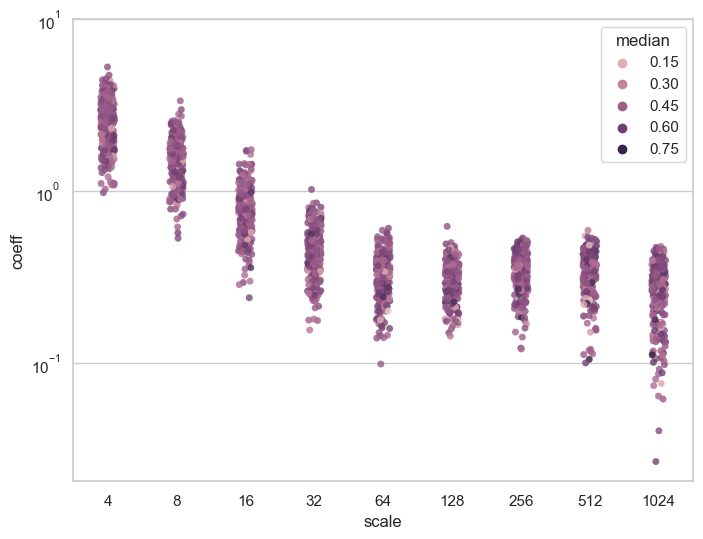

In [238]:
sns.set(style="whitegrid")
data = df.pivot(index="scale", columns="image", values="coeff")

# ax = sns.heatmap(data,  cbar_kws={'label': 'Coefficient of distortion'})
# ax = sns.scatterplot(x="scale", y="coeff", hue="image", data=df)
# ax = sns.lineplot(x="scale", y="coeff", data=df, hue="image", legend=False, estimator=np.median, errorbar=('ci',95))

# Plot point plot 
# ax = sns.lineplot(x="scale", y="coeff", data=df, estimator=np.median)
ax = sns.stripplot(x="scale", y="coeff", data=df, hue="median", legend=True, alpha=0.8)

# Regplot 
# ax = sns.regplot(x="scale", y="coeff", data=df, x_estimator=np.median, x_ci=95, scatter=False, color='red')

ax.figure.set_size_inches(8, 6)

# set x axis to log scale
# ax.set_xscale('log')

# set y axis to log scale
ax.set_yscale('log')

# Set y lims 
ax.set_ylim(0, 10)

plt.show()